# Прогнозирование вероятности оттока пользователей для фитнес-центров

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.
В отток записываются те, кто попросил закрыть договор или удалил аккаунт.
Также в отток попадают те, кто просто перестал пользоваться сервисом.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.
Чтобы бороться с оттоком, в электронный вид было переведены клиентские анкеты.

Задача — провести анализ и подготовить план действий по удержанию клиентов.<br>
А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 1. выделить целевые группы клиентов;
 2. предложить меры по снижению оттока;
 3. определить другие особенности взаимодействия с клиентами.

<a id="first"></a>
Проект выполнен в следующем порядке:
1. [Загрузка данных](#start)
2. [Исследовательский анализ данных (EDA)](#step2)
3. [Построение модели прогнозирования оттока клиентов](#step3)
4. [Кластеризация клиентов](#step4)
5. [Выводы и базовые рекомендации по работе с клиентами](#finish)

<a id="start"></a>
## 1. Загрузка данных

In [96]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime
from scipy import stats as st
import seaborn as sns
import scipy.stats as stats
import time
from plotly import graph_objects as go
import math as mth
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#импорт необходимых библиотек

In [97]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [98]:
#path = 'C://Users//79313//11//'
path = '/datasets/'
data = pd.read_csv(path + 'gym_churn.csv', sep=",")

In [99]:
display(data.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Значения полей:<br>
* 'Churn' — факт оттока в текущем месяце;<br>
* 'gender' — пол;<br>
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;<br>
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);<br>
* 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);<br>
* 'Phone' — наличие контактного телефона;<br>
* 'Age' — возраст;<br>
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);<br>
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);<br>
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);<br>
* 'Group_visits' — факт посещения групповых занятий;<br>
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;<br>
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;<br>
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

[Наверх](#first)
<a id="step2"></a>
## 2. Исследовательский анализ данных (EDA)

In [100]:
data.columns = map(str.lower, data.columns) 

Для удобства в работе приводим все названия столбцов к нижнему регистру.

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В датасете нет пропусков данные, изменение типов данных не требуется.<br>
Категориальные признаки отсутствуют.

В датасете 13 признаков и 1 целевая переменная ('churn')

In [102]:
print('Всего дубликатов:',data.duplicated().sum()) #просмотр количества дубликатов

Всего дубликатов: 0


In [103]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Наблюдение по полям:<br>
* 'gender': значения 0 и 1, распределение клиентов близко к 50 на 50;<br>
* 'near_Location': значения 0 и 1, большая часть клиентов проживают рядом с клубом;<br>
* 'partner': значения 0 и 1, половина клиентов приходит в клуб по партнёрской программе;<br>
* 'promo_friends': значения 0 и 1, большая часть клиентов приходит НЕ по акции "приведи друга";<br>
* 'phone': значения 0 и 1, большая часть клиентов предоставила номер телефона;<br>
* 'contract_period': длительность текущего действующего абонемента в среднем - 4.7 месяцев;<br>
* 'group_visits': значения 0 и 1, 41% клиентов посещают групповые занятия;<br>
* 'age': средний возраст 29 лет;<br>
* 'avg_additional_charges_total': суммарная выручка от других услуг фитнес-центра - 146 денежных едениц;<br>
* 'month_to_end_contract': средний срок до окончания текущего действующего абонемента 4.3 месяцев;<br>
* 'lifetime': среднее время с момента первого обращения в фитнес-центр - 3.7 месяцев;<br>
* 'avg_class_frequency_total': средняя частота посещений в неделю за все время с начала действия абонемента - 1.8 раз;<br>
* 'avg_class_frequency_current_month': средняя частота посещений в неделю за предыдущий месяц - 1.7 раз;<br>
* 'churn': 1, если отток случился, 0 - если пользователь остаётся. Среднее значение 0.26, большая часть пользователей остаётся в клубе.

In [104]:
display(data.groupby('churn')[['gender','near_location','partner','promo_friends',\
        'phone','contract_period','group_visits','age','avg_additional_charges_total']].mean())
display(data.groupby('churn')[['month_to_end_contract','lifetime','avg_class_frequency_total','avg_class_frequency_current_month']].mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total
churn,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899


,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,
0,5.283089,4.711807,2.024876,2.027882
1,1.662582,0.990575,1.474995,1.044546


По признакам в отток попадают:
* 'gender': мужчины и женщины в одинаковом соотношении;<br>
* 'near_Location': больше пользователей, НЕ проживающих рядом с клубом;<br>
* 'partner': больше пользователей, которые пришли в клуб НЕ по партнёрской программе;<br>
* 'promo_friends': больше пользователей, которые пришли в клуб НЕ по акции "приведи друга";<br>
* 'phone': одинаковое соотношение пользователей по факту предоставления номера телефона;<br>
* 'contract_period': больше пользователей с коротким абонементом;<br>
* 'group_visits': больше пользователей, НЕ посещавших групповые занятия;<br>
* 'age': более молодые пользователи;<br>
* 'avg_additional_charges_total': пользователи с меньшей суммарной выручкой;<br>
* 'month_to_end_contract': пользователи, с меньшим сроком до окончания текущего абонемента (может быть связано с общим коротким сроком абонемента);<br>
* 'lifetime': с меньшим временем от первого обращения в клуб <br>
* 'avg_class_frequency_total': с меньшей частотой посещений в неделю за все время с начала действия абонемента;<br>
* 'avg_class_frequency_current_month': с меньшей частотой посещений в неделю за предыдущий месяц.

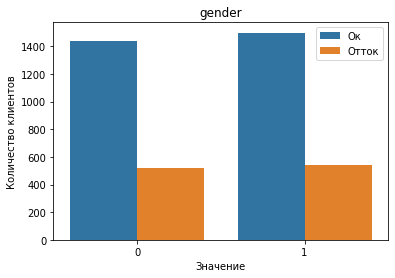

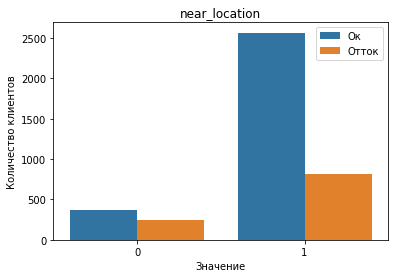

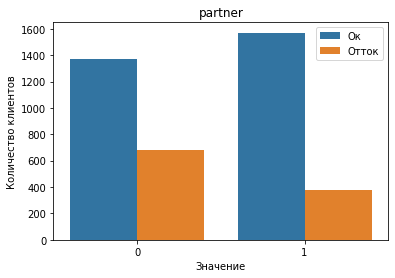

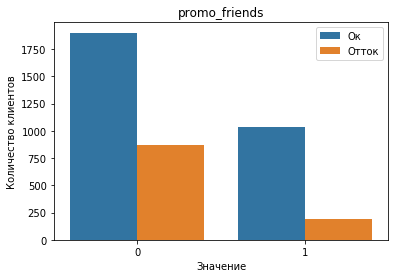

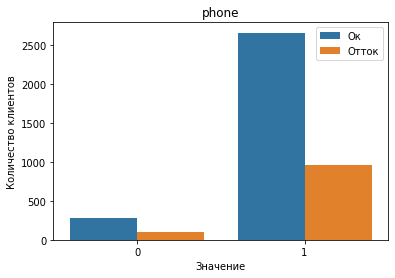

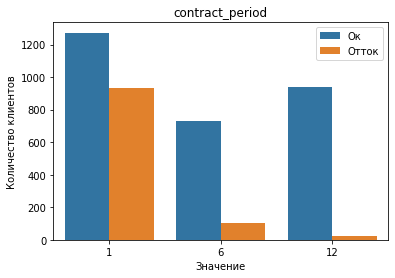

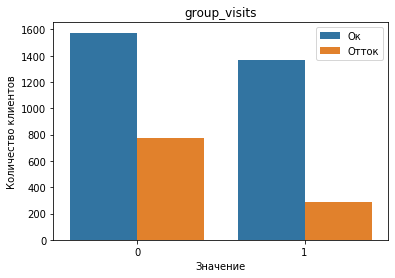

In [105]:
for col in data[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']].columns:
    ax = sns.countplot(x=col, hue='churn', data=data)
    plt.title(col)
    plt.ylabel("Количество клиентов")
    plt.xlabel("Значение")
    plt.legend(['Ок', 'Отток'])
    plt.show()   

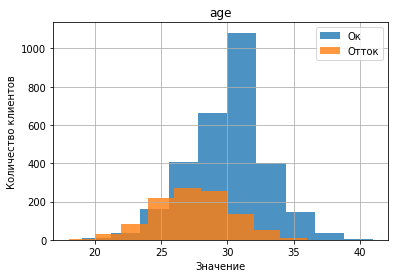

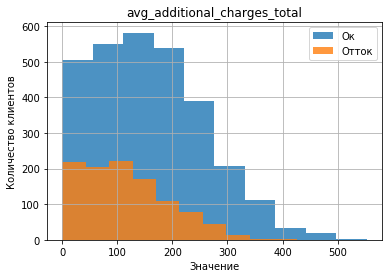

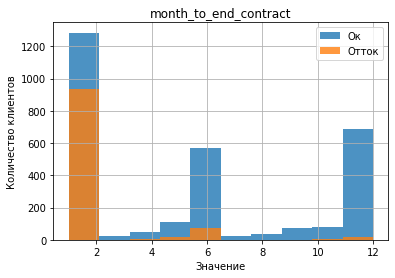

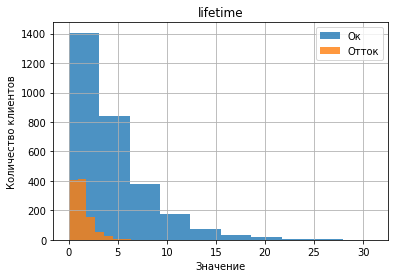

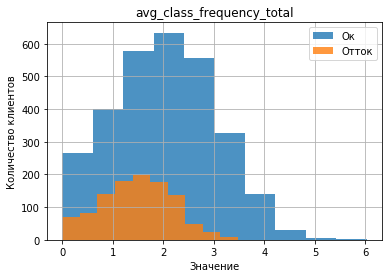

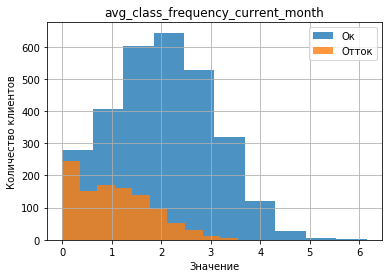

In [106]:
for col in data[['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',\
                 'avg_class_frequency_current_month']].columns:
    plt.hist(data.query('churn == 0')[col], alpha=0.8)
    plt.hist(data.query('churn == 1')[col], alpha=0.8)
    plt.title(col)
    plt.ylabel("Количество клиентов")
    plt.xlabel("Значение")
    plt.grid()
    plt.legend(['Ок', 'Отток'])
    plt.show()
    

Выводы, аналогичные предыдущим отображены на гистограммах.

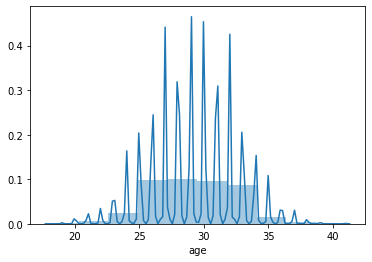

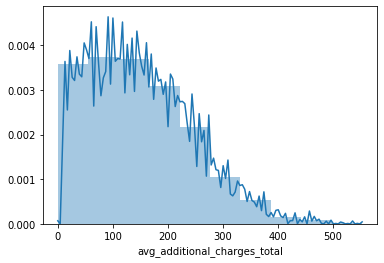

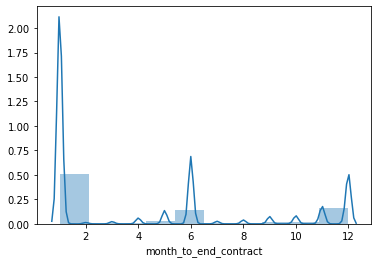

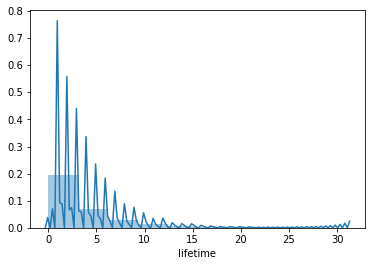

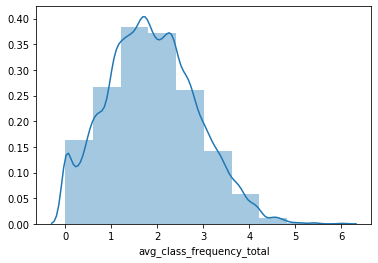

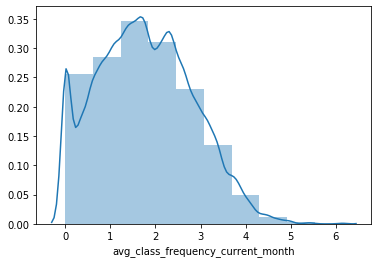

In [107]:
for feature in data[['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',\
                 'avg_class_frequency_current_month']].columns:
  sns.distplot(data[feature], bins = 10, kde_kws={'bw':0.1})
  plt.show() 

Графики age, avg_class_frequency_total - выглядят как график стандартного нормального распределения.

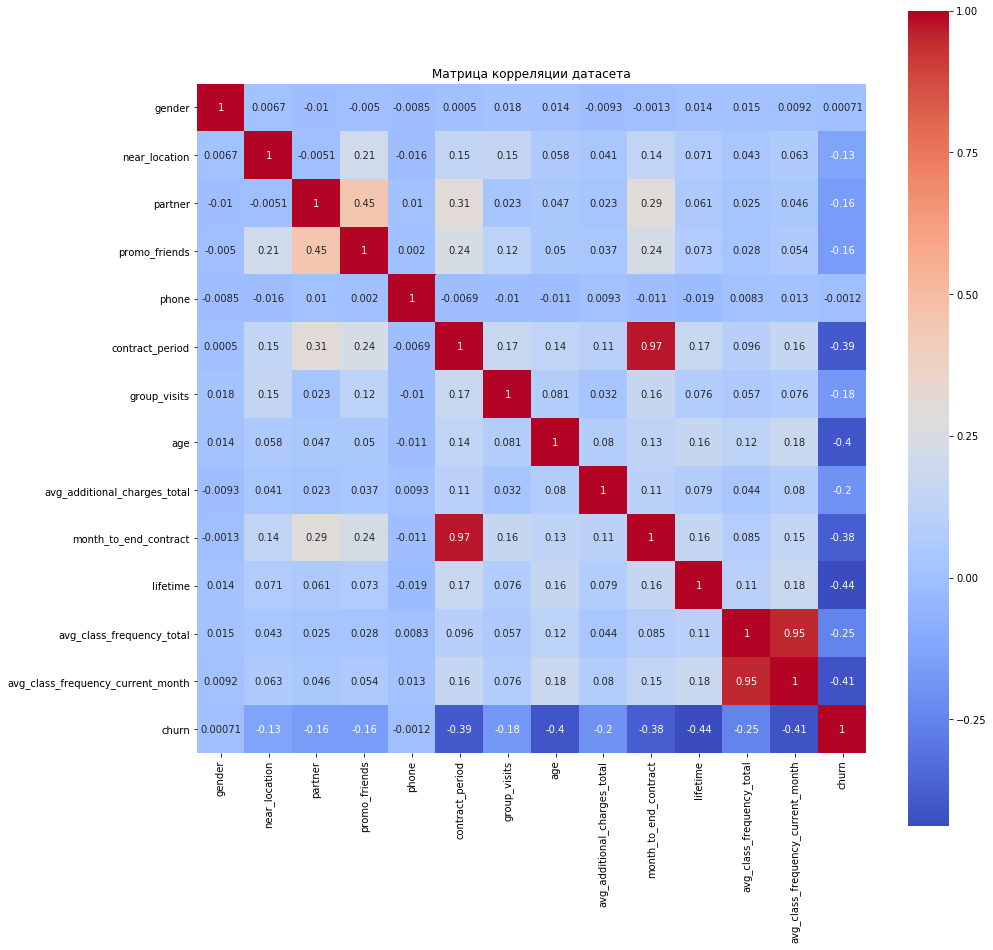

In [108]:
corr_m = data.corr()

plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True, cmap='coolwarm')
plt.title('Матрица корреляции датасета')
plt.show()

Высокая корреляция между признаками:
* month_to_end_contract и contract_period
* avg_class_frequency_total и avg_class_frequency_current_month

### Вывод
Данные подготовлены к дальнейшему построению моделей.<br>
Для корректной работы необходимо учитывать коррелирующие признаки: month_to_end_contract и contract_period, avg_class_frequency_total и avg_class_frequency_current_month.<br>
Также необходимо провести стандартизацию данных.

[Наверх](#first)
<a id="step3"></a>
## 3. Построение модели прогнозирования оттока клиентов

In [129]:
X = data\
    .drop(['churn', 'avg_class_frequency_current_month', 'month_to_end_contract'], axis = 1)
y = data['churn']


Разделяем данные на признаки (матрица X) и целевую переменную (y).<br>
Также удаляем столбы 'avg_class_frequency_current_month' и 'month_to_end_contract' как коррелирующие.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Разделяем модель на тестовую (X_test) и валидационую (X_train) выборки.<br>
Пропорция тестовой и валидационной выборки: 80/20.<br>
Параметр случайности random_state приравняем к нолю.

In [131]:
scaler = StandardScaler()
scaler.fit(X_train)# обучение scaler на обучающей выборке методом fit
X_train_st = scaler.transform(X_train) # стандартизация валидационной выборки методом transform scaler 
X_test_st = scaler.transform(X_test) # стандартизация тестовой выборки методом transform scaler

Стандартизируем тестовую и валидационную выборки методом StandardScaler

### Обучение модели методом логистической регрессии.

In [132]:
model_lr = LogisticRegression(random_state=0)

Задаём для модели для модели алгоритм логистической регрессии с нулевым random_state.

In [133]:
model_lr.fit(X_train_st, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Обучаем модель.

In [134]:
predictions_lr = model_lr.predict(X_test_st)

Создаём прогноз.

In [135]:
probabilities_lr = model_lr.predict_proba(X_test_st)[:,1]

Определяем вероятность принадлежности объекта к первому или второму классу.

### Обучение модели методом случайного леса.

In [136]:
model_forest = RandomForestClassifier(random_state=0)

Задаём для модели для модели алгоритм случайного леса с нулевым random_state.

In [137]:
model_forest.fit(X_train_st, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Обучаем модель.

In [138]:
predictions_forest = model_forest.predict(X_test_st)

Создаём прогноз.

### Сравнение выбранных моделей.

In [139]:
def metrics (y_test, pred):
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, pred)))

In [140]:
print('Логистическая регрессия:')
metrics(y_test, predictions_lr)

Логистическая регрессия:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
ROC_AUC: 0.94


In [141]:
print('Случайный лес:')
metrics(y_test, predictions_forest)

Случайный лес:
Accuracy: 0.94
Precision: 0.97
Recall: 0.91
ROC_AUC: 0.94


### Улучшение прогноза

In [27]:
def automatic(X, y, z):
    print(z)
    print('             ')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #Разделяем модель на тестовую и валидационую выборки.
    scaler = StandardScaler()
    scaler.fit(X_train)# обучение scaler на обучающей выборке методом fit
    X_train_st = scaler.transform(X_train) # стандартизация валидационной выборки методом transform scaler 
    X_test_st = scaler.transform(X_test) # стандартизация тестовой выборки методом transform scaler
    model_lr = LogisticRegression(random_state=0) #задаём для модели для модели алгоритм логистической регрессии
    model_lr.fit(X_train_st, y_train) #обучаем модель
    predictions_lr = model_lr.predict(X_test_st) #создаём прогноз
    model_forest = RandomForestClassifier(random_state=0) #задаём для модели для модели алгоритм случайного леса
    model_forest.fit(X_train_st, y_train) #обучаем модель
    predictions_forest = model_forest.predict(X_test_st) #создаём прогноз
    print('Логистическая регрессия:')
    metrics(y_test, predictions_lr)
    print('             ')
    print('Случайный лес:')
    metrics(y_test, predictions_forest)

Автоматизируем ранее созданный алгоритм от стандартизации до расчёта метрик по моделям.

In [28]:
X1 = data.drop(['churn', 'avg_class_frequency_total', 'contract_period'], axis = 1)

Разделяем данные на признаки (матрица X1) и целевую переменную (y).
Также удаляем столбы 'avg_class_frequency_total' и 'contract_period' как коррелирующие (парные столбцы от удаленных в предыдущем расчете).

In [29]:
automatic(X1, y, 'Вторые переменные из пары')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Вторые переменные из пары
             
Логистическая регрессия:
Accuracy: 0.90
Precision: 0.79
Recall: 0.82
ROC_AUC: 0.88
             
Случайный лес:
Accuracy: 0.89
Precision: 0.79
Recall: 0.76
ROC_AUC: 0.85


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



При использовании логистической регрессии показатели Recall и ROC_AUC выше. Необходимо удалять коррелирующие столбцы 'avg_class_frequency_total' и 'contract_period'.

In [30]:
def stratify(X, y, z):
    print(z)
    print('             ')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) #Разделяем модель на тестовую и валидационую выборки.
    scaler = StandardScaler()
    scaler.fit(X_train)# обучение scaler на обучающей выборке методом fit
    X_train_st = scaler.transform(X_train) # стандартизация валидационной выборки методом transform scaler 
    X_test_st = scaler.transform(X_test) # стандартизация тестовой выборки методом transform scaler
    model_lr = LogisticRegression(random_state=0) #задаём для модели для модели алгоритм логистической регрессии
    model_lr.fit(X_train_st, y_train) #обучаем модель
    predictions_lr = model_lr.predict(X_test_st) #создаём прогноз
    model_forest = RandomForestClassifier(random_state=0) #задаём для модели для модели алгоритм случайного леса
    model_forest.fit(X_train_st, y_train) #обучаем модель
    predictions_forest = model_forest.predict(X_test_st) #создаём прогноз
    print('Логистическая регрессия:')
    metrics(y_test, predictions_lr)
    print('             ')
    print('Случайный лес:')
    metrics(y_test, predictions_forest)

Добавляем в функцию параметр stratify.

In [31]:
stratify(X1, y, 'Вторые переменные из пары')

Вторые переменные из пары
             


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Логистическая регрессия:
Accuracy: 0.92
Precision: 0.84
Recall: 0.84
ROC_AUC: 0.89
             
Случайный лес:
Accuracy: 0.89
Precision: 0.85
Recall: 0.73
ROC_AUC: 0.84


Показатели метрик улучшились.

### Вывод
Согласно совокупности показателей (более высокие Precision, Recall, F1 и ROC_AUC) предпочтительно использовать модель логистической регрессии.<br>
Также необходимо испольтзовать параметр stratify, а также удалять коррелирующие признаки: 'avg_class_frequency_total', 'contract_period'.

[Наверх](#first)
<a id="step4"></a>
## 4. Кластеризация клиентов

In [32]:
sc = StandardScaler()
X_sc = sc.fit_transform(data.drop('churn', axis=1))

Стандартизируем данные.

In [33]:
linked = linkage(X_sc, method = 'ward') 

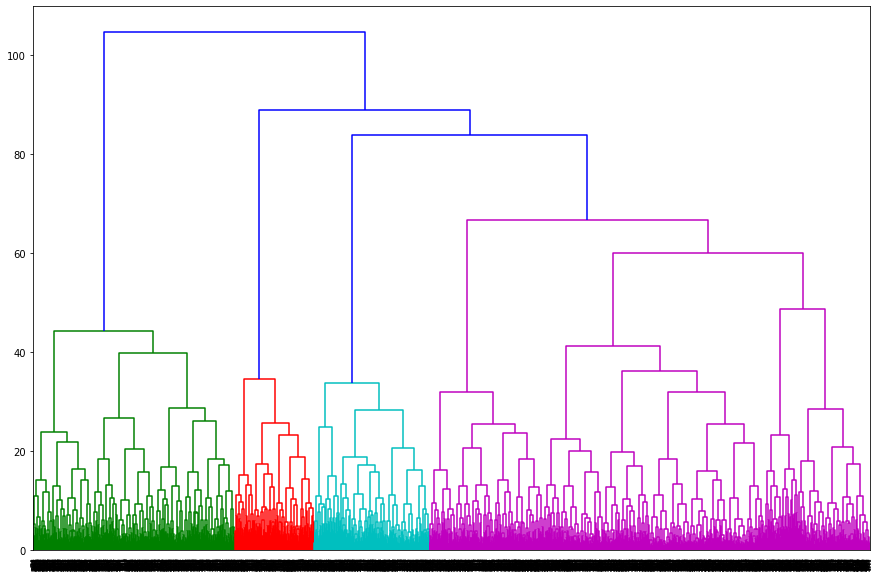

In [34]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Согласно дендрограмме необходимо принять условие - 5 кластеров.

In [35]:
km = KMeans(n_clusters = 5, random_state=0)

Прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)

In [36]:
labels = km.fit_predict(X_sc)

In [37]:
data['cluster'] = labels

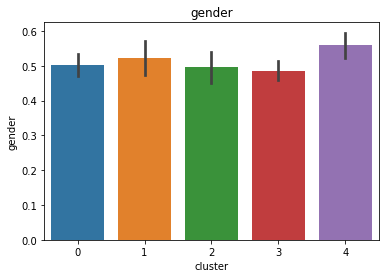

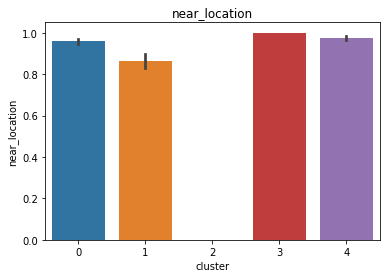

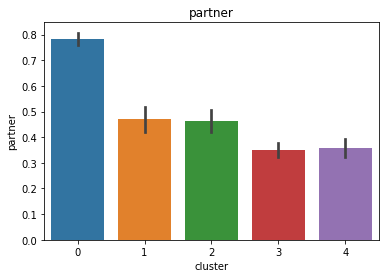

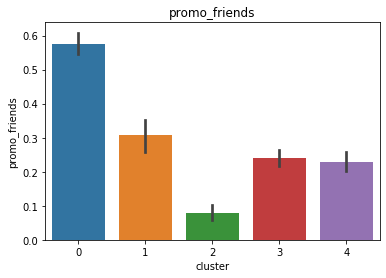

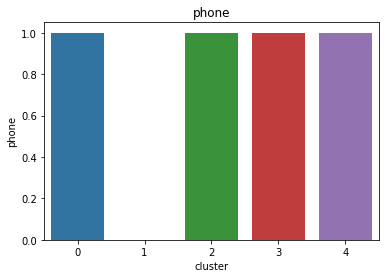

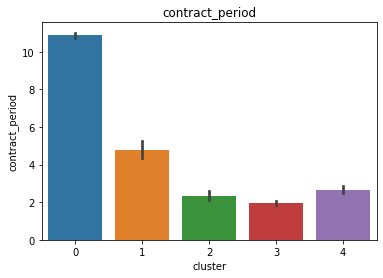

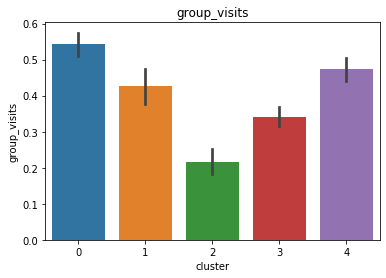

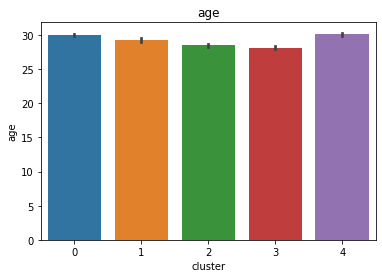

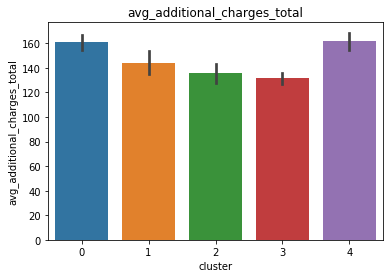

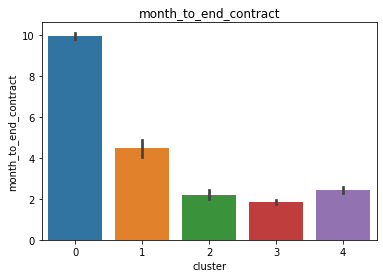

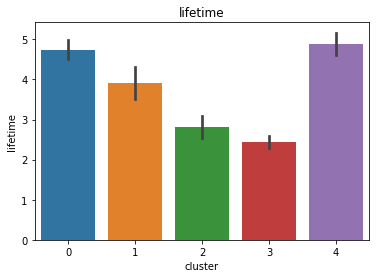

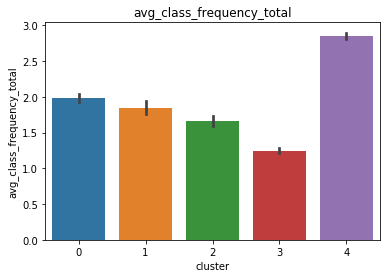

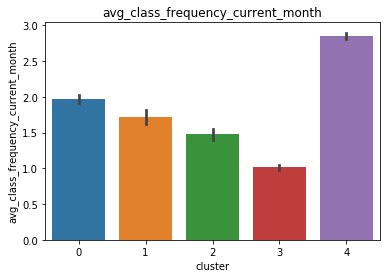

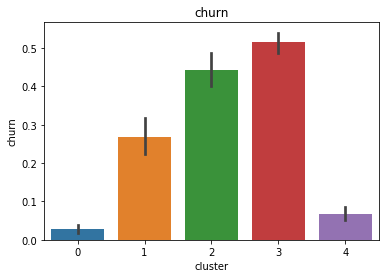

In [38]:
for col in data.drop('cluster', axis=1).columns:
    ax = sns.barplot(x="cluster", y=col, data=data)
    plt.title(col)
    plt.show()

Портет пользователя по кластерам, характерные особенности:
<table>
    <tr>
        <td>критерий</td>
        <td>0 кластер</td>
        <td>1 кластер</td>
        <td>2 кластер</td>
        <td>3 кластер</td>
        <td>4 кластер</td>
    </tr>
    <tr>
        <td>партнерская программа</td>
        <td>средний</td>
        <td>нет</td>
        <td>средний</td>
        <td>все</td>
        <td>высокий</td>
    </tr>
    <tr>
        <td>приведи друга</td>
        <td>средний</td>
        <td>низкий</td>
        <td>низкий</td>
        <td>высокий</td>
        <td>высокий</td>
    </tr>
    <tr>
        <td>номер телефона</td>
        <td>нет</td>
        <td>все</td>
        <td>все</td>
        <td>все</td>
        <td>все</td>
    </tr>
    <tr>
        <td>срок действия абонемента</td>
        <td>6 мес</td>
        <td>3 мес</td>
        <td>3мес</td>
        <td>3мес</td>
        <td>12мес</td>
    </tr>
    <tr>
        <td>групповые занятия</td>
        <td>средний</td>
        <td>меньше</td>
        <td>средний</td>
        <td>меньше</td>
        <td>больше</td>
    </tr>
    <tr>
        <td>выручка</td>
        <td>средний</td>
        <td>меньше</td>
        <td>выше</td>
        <td>меньше</td>
        <td>выше</td>
    </tr>
    <tr>
        <td>время жизни</td>
        <td>среднее</td>
        <td>меньше</td>
        <td>выше</td>
        <td>меньше</td>
        <td>выше</td>
    </tr>
    <tr>
        <td>частота групповых</td>
        <td>среднее</td>
        <td>меньше</td>
        <td>выше</td>
        <td>меньше</td>
        <td>среднее</td>
    </tr>
</table>

In [39]:
print(data.groupby('cluster')['churn'].mean())

cluster
0    0.027695
1    0.267532
2    0.443564
3    0.514263
4    0.068100
Name: churn, dtype: float64


В кластерах 1, 3, 0 - наивысший показатель оттока (от 26% до 55%).<br>
В кластерах 2, 4 - показатель наименьший, составляет менее 5%.

### Вывод
Формируется следующий портет клиента в кластерах с высокими показателями оттока:
* не предоставляет номер телефона;
* не посещает групповые занятия (либо посещает их с низкой частотой);
* низкая выручка от других услуг фитнес центра;
* малое время от первого обращения в фитнес центр.

[Наверх](#first)
<a id="finish"></a>
## 5. Выводы и базовые рекомендации по работе с клиентами

1. Обязательно фиксировать номер телефона клиента;
2. Вовлекать клиента в групповые занятия (бесплатный блок первых занятий, максимально дружелюбные тренеры);
3. Продвигать клиенту дополнительные услуги фитнес центра (бесплатные тестовые образцы, скидки для новых клиентов);
4. Активно "опекать" клиента в первые месяцы использования абонемента (программы поддержки и мотивации для новичков, опросы удовлетворенности).


Рекомендация для специалистов по прогнозам: для построения прогнозов предпочтительно использовать модель логистической регрессии.